## CS 5180 Reinforcement Learning and Sequential Decision Making
### Exercise 5: Off-Policy Monte-Carlo & Temporal-Difference Learning

In [4]:
%load_ext autoreload
%autoreload 2
import numpy as np
from environment import RandomWalk, FourRooms
import algorithms
from collections import defaultdict
import matplotlib.pyplot as plt
import pickle
from matplotlib import cm

## Q3 Random-walk task

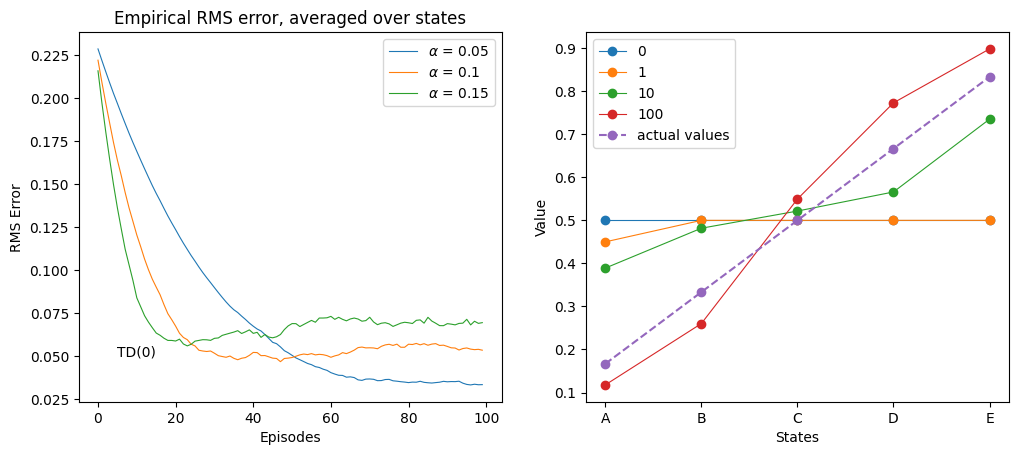

In [116]:
rw = RandomWalk()
V = {s:0.5 for s in rw.state_space}
V["T0"] = 0
V["T1"] = 0

ideal_V = np.array([1/6, 2/6, 3/6, 4/6, 5/6])

num_episodes = 100
alpha = [0.05, 0.1, 0.15]
gamma = 1

trials = 100
rms = np.zeros([trials, num_episodes])

fig = plt.figure(figsize=plt.figaspect(0.4))
ax_1 = fig.add_subplot(1, 2, 1)
ax_2 = fig.add_subplot(1, 2, 2)

plot_val_episodes = [0,1,10,100]

for a in alpha:
    for t in range(trials):
        val_function, rms[t,:] = algorithms.td_0(rw, V, num_episodes, a, gamma, calc_rms=True, ideal_V=ideal_V)

    ax_1.plot(np.mean(rms, axis=0), label = f"$\\alpha$ = {a}", linewidth = 0.8)

for e in plot_val_episodes:
    val_function, _ = algorithms.td_0(rw, V, e, 0.1, gamma, calc_rms=True, ideal_V=ideal_V)
    ax_2.plot(list(val_function.values())[1:-1], marker = "o", lw=0.8, label=F"{e}")
ax_2.plot(ideal_V, "--o", label = "actual values")
ax_2.set_xticks(range(len(rw.state_space[1:-1])))
ax_2.set_xticklabels(rw.state_space[1:-1])


ax_1.legend()
ax_1.set_title("Empirical RMS error, averaged over states")
ax_1.set_xlabel("Episodes")
ax_1.set_ylabel("RMS Error")
ax_1.text(5, 0.05, "TD(0)")
ax_2.legend()
ax_2.set_xlabel("States")
ax_2.set_ylabel("Value")
plt.show()

## Written
### Q3 (a) 

It is evident from the graph that the first episode terminated in the terminal state with reward 0, since only the value of A has been updated. From the $TD(0)$ equation:

$V(S)\gets V(S)+\alpha [R+\gamma V(S') - V(S)]$. So if the episode terminated with a reward of 0, then

$\alpha = 0.1$, $\gamma = 1$, $V(S')=0$, $V(A) = 0.5$. Therefore:

$V(A) \gets 0.5 + 0.1[0 + 0 - 0.5]$

$V(A) = 0.45$

The values of all the other states remain unchanged because values of all states were initialized to 0.5 (except the terminal states):

$V(S)\gets V(S)+ 0.1[0+ 0.5 - 0.5]$

$V(S) = V(S)$

### Q3(b)
It looks like the RMS error of TD increases after a point with a large value of alpha. This makes sense since $V(S) = (1-\alpha)V(S) + \alpha(R+\gamma V(S'))$. So increasing the value of alpha means that $V(S)$ depends more on the immediate reward and the value of the next state and hence is prone to drift once $V(S)$ is near its true value. I don't think evaluating which algorithm is better would change if more range of values of alpha were tested since MC only makes an estimate for the value at the end of an episode once, while TD updates the estimate at each step. 

### Q3 (c)
Initialization of the values does have a small impact on the RMS error, but the overall behavior will remain unchanged. As the estimates near the true values, high alpha will cause the RMS to increase due to reasons discussed in 3(b). This is evident in a small test I performed in which I initialized the values to zero. Since this estimate is far off from the true value, it takes longer for convergence and RMS increases for large values of alpha as seen in the plots below.


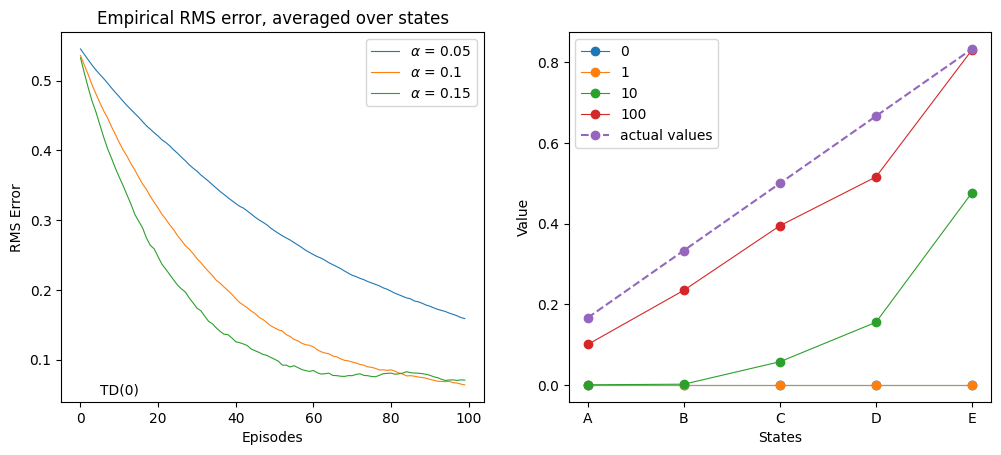

## Q4 Four Rooms, continued

#### Q4(a) Collect sample data from each source of behavior data

In [5]:
four_rooms = FourRooms()

#### Generating 10000 episodes of random policy

In [9]:
random_policy = {s:[0.25, 0.25, 0.25, 0.25] for s in four_rooms.state_space}
ep_random_policy = []

for _ in range(10000):
    ep_random_policy.append(algorithms.generate_episode(four_rooms, random_policy))

with open("ep_random_policy", "wb") as f:
    pickle.dump(ep_random_policy, f)

In [6]:
with open("ep_random_policy", "rb") as f:
    ep_random_policy = pickle.load(f)

#### Running on-policy MC control for 10000 episodes and $\epsilon$ = 0.1

In [115]:
gamma = 0.9
num_episodes = 10000
num_trials = 1
eps = 0.1
policy_mc_on, _, q_mc_on, ep_mc_on = algorithms.mc_e_soft(four_rooms, random_policy, gamma, num_episodes, num_trials, eps)

with open("ep_mc_on", "wb") as f:
    pickle.dump(ep_mc_on, f)

with open("q_mc_on", "wb") as f:
    pickle.dump(q_mc_on, f)

with open("policy_mc_on", "wb") as f:
    pickle.dump(policy_mc_on, f)

In [12]:
with open("ep_mc_on", "rb") as f:
    ep_mc_on = pickle.load(f)

with open("q_mc_on", "rb") as f:
    q_mc_on = pickle.load(f)

with open("policy_mc_on", "rb") as f:
    policy_mc_on = pickle.load(f)

#### Q4 (b) Computing a greedy policy $\pi_{greedy}$ based on Q values estimated from $\epsilon$-soft policy

In [13]:
policy_greedy = {s:[0, 0, 0, 0] for s in four_rooms.state_space}

for s in four_rooms.state_space:
    best_val = -np.inf
    for idx_a, a in enumerate(four_rooms.action_space):
        if q_mc_on[(s, a.value)] > best_val:
            best_val = q_mc_on[(s, a.value)]
            policy_greedy[s] = [0,0,0,0]
            policy_greedy[s][idx_a] = 1

#### Plotting of the $\pi_{greedy}$ policy

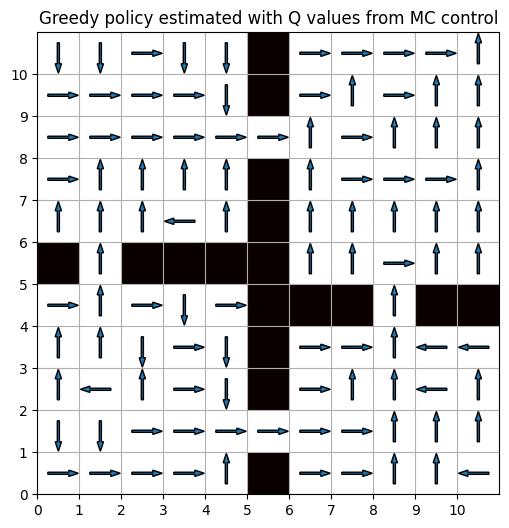

In [118]:
policy_plot = np.ones([four_rooms.dim, four_rooms.dim])

for w in four_rooms.WALLS:
    policy_plot[(w[1], w[0])] = 0

fig = plt.figure(figsize=(6,6))
ax = plt.subplot(1, 1, 1)
ax.imshow(policy_plot, origin="lower", cmap = cm.hot)

for state in policy_greedy:
    action = np.nonzero(policy_greedy[state])[0][0]
    if action == 0:
        x = state[0]
        y = state[1] - 0.25
        dx = 0
        dy = 0.5

    if action == 1:
        x = state[0]
        y = state[1] + 0.25
        dx = 0
        dy = -0.5

    if action == 2:
        x = state[0] + 0.25
        y = state[1]
        dx = -0.5
        dy = 0

    if action == 3:
        x = state[0] - 0.25
        y = state[1]
        dx = 0.5
        dy = 0

    ax.arrow(x, y, dx, dy, width = 0.05)

ax.set_xticks(np.arange(-0.5, 10, 1))
ax.set_yticks(np.arange(-0.5, 10, 1))
ax.set_xticklabels(range(11))
ax.set_yticklabels(range(11))
ax.set_title("Greedy policy estimated with Q values from MC control")
ax.grid("on")

#### Written: 
This policy makes sense for majority of the states, although there are a few exceptions. Like for example in the state (2, 2), (2, 10), (4, 4) etc. Also this policy changes each time I run the algorithm. This makes sense since there is a bit of stochasticity in the $\epsilon$-soft policy, which leads to a slightly different Q values and a slightly different greedy policy.

#### Q4 (c) Off-policy MC control

#### Estimating values of $\pi_{greedy}$ with a random policy

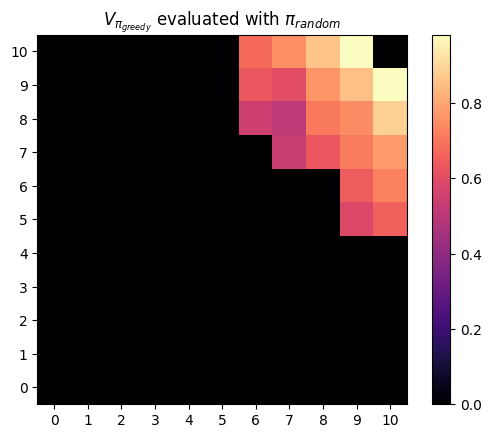

In [144]:
q_val_est_random = algorithms.mc_off_policy(four_rooms, ep_random_policy, random_policy, policy_greedy, num_episodes=10000, gamma=0.9) 
val_function = np.zeros([four_rooms.dim, four_rooms.dim])

for s in four_rooms.state_space:
    action_idx = policy_greedy[s].index(1)
    val_function[s[1], s[0]] = q_val_est_random[(s, four_rooms.action_space.get(action_idx))]

plt.imshow(val_function, origin="lower", cmap=cm.magma)
plt.xticks(range(11))
plt.yticks(range(11))
plt.title("$V_{\pi_{greedy}}$ evaluated with $\pi_{random}$")
plt.colorbar()
plt.show()

#### Estimating values of $\pi_{greedy}$ with an $\epsilon$-soft policy

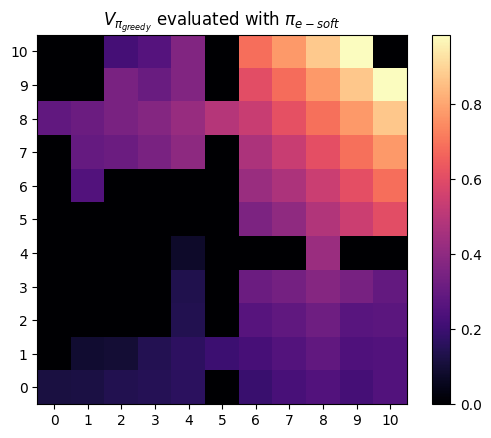

In [14]:
q_val_est_esoft  = algorithms.mc_off_policy(four_rooms, ep_mc_on, policy_mc_on , policy_greedy, num_episodes=10000, gamma= 0.9)
val_function = np.zeros([four_rooms.dim, four_rooms.dim])
for s in four_rooms.state_space:
    action_idx = policy_greedy[s].index(1)
    val_function[s[1], s[0]] = q_val_est_esoft[(s, four_rooms.action_space.get(action_idx))]

plt.imshow(val_function, origin="lower", cmap=cm.magma)
plt.xticks(range(11))
plt.yticks(range(11))
plt.title("$V_{\pi_{greedy}}$ evaluated with $\pi_{e-soft}$")
plt.colorbar()
plt.show()

#### Q4 (d) On policy MC prediction

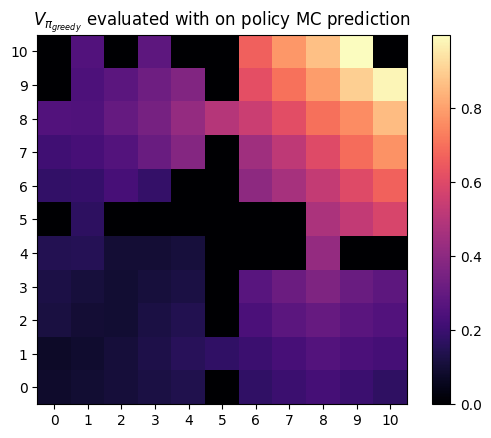

In [146]:
q_pred = algorithms.mc_on_policy_pred(four_rooms, policy_greedy, num_episodes=10000, gamma=0.9)

val_function = np.zeros([four_rooms.dim, four_rooms.dim])
for s in four_rooms.state_space:
    action_idx = policy_greedy[s].index(1)
    val_function[s[1], s[0]] = q_pred[(s, four_rooms.action_space.get(action_idx))]

plt.imshow(val_function, origin="lower", cmap=cm.magma)
plt.xticks(range(11))
plt.yticks(range(11))
plt.title("$V_{\pi_{greedy}}$ evaluated with on policy MC prediction")
plt.colorbar()
plt.show()

#### Q4 (e) Written

The importance sampling ratio is given as $\frac{\pi(A_t|S_t)}{b(A_t|S_t)}$. Since at some point the importance-sampling ratio will definitely go to zero, given that the behavior policy will take an action that is not taken by the greedy policy (in a given state), it means that we cannot estimate the values of all the states under the target policy. This means that a policy similar to the greedy target policy will be able to better estimate its action values over greater number of states. This trend is clearly visible in the plots above. When the behaviour policy is a random policy, then for most states the importance sampling ratio is zero and hence the value of a few states near the goal is evaluated. For when the behavior policy is the $\epsilon$-soft policy, it is more similar to the target greedy policy and hence values of most of the states are evaluated. Although the values for the states estimated via off-policy methods and the on policy MC methods are the same as seen in the heatmaps, where the values of states near the goal are high.